In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

#TS Fresh Parameter Settings
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import extract_features

import matplotlib.patches as mpatches

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


In [2]:
## Helper function to return accuracy dataframe for each file
def return_acc_df(results_df):
    '''
    Input : Dataframe containing all raw results from hyperparameter tuning
    Output: Dataframe with accuracy per region for that classifier
    '''
    results_df = results_df.drop(columns = [col for col in results_df.columns if 'params' in col] +  [col for col in results_df.columns if 'results' in col] )
    res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)
    acc_df = res_df[[col for col in res_df.columns if 'acc' in col]]
    mean_acc_df = pd.DataFrame( acc_df.mean(axis=0) ).T
    
    return mean_acc_df

In [7]:
TS_Fresh_setting = 'Minimal'
models = ['Ada' , 'DT', 'RF' , 'SVC']
expt_nums = ['1', '2']

#Set vals to test load(ing) a file
expt_num = '1'
data_type = 'N1'
model = 'RF'

folder = 'hyperparameter_tuning_results/expts_3/'
file_name = model + '_' + data_type + '_' + 'bpw_only_' + TS_Fresh_setting + '_' + 'expt' + str(expt_num) + '_' +  str(4) + '_fold_results_df.pkl'

all_results_df = joblib.load(folder+file_name)

In [8]:
all_results_df

,random_state,y_true,Prefrontal_RF_y_preds,y_train,Prefrontal_RF_best_clf_params,Prefrontal_RF_cv_results,Prefrontal_RF_y_train_preds,Frontal_RF_y_preds,Frontal_RF_best_clf_params,Frontal_RF_cv_results,...,Left Parietal_RF_cv_results,Left Parietal_RF_y_train_preds,Right Parietal_RF_y_preds,Right Parietal_RF_best_clf_params,Right Parietal_RF_cv_results,Right Parietal_RF_y_train_preds,Occipital_RF_y_preds,Occipital_RF_best_clf_params,Occipital_RF_cv_results,Occipital_RF_y_train_preds
0,1,"[[0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 1, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[{'criterion': 'gini', 'max_depth': 2, 'max_fe...",mean_fit_time std_fit_time mean_score_t...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'criterion': 'gini', 'max_depth': 2, 'max_fe...",mean_fit_time std_fit_time mean_score_t...,...,mean_fit_time std_fit_time mean_score_t...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 1, 0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, ...","[{'criterion': 'gini', 'max_depth': 8, 'max_fe...",mean_fit_time std_fit_time mean_score_t...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 1, 0, ...","[{'criterion': 'gini', 'max_depth': 2, 'max_fe...",mean_fit_time std_fit_time mean_score_t...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,2,"[[0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 1, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[{'criterion': 'gini', 'max_depth': 3, 'max_fe...",mean_fit_time std_fit_time mean_score_t...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 0, ...","[{'criterion': 'gini', 'max_depth': 2, 'max_fe...",mean_fit_time std_fit_time mean_score_t...,...,mean_fit_time std_fit_time mean_score_t...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 1, 0, ...","[{'criterion': 'entropy', 'max_depth': 5, 'max...",mean_fit_time std_fit_time mean_score_t...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 1, 0, 0, 0, 1, 1, 1], [1, 0, 0, 1, 1, 0, ...","[{'criterion': 'entropy', 'max_depth': 3, 'max...",mean_fit_time std_fit_time mean_score_t...,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,..."


<Figure size 640x480 with 0 Axes>

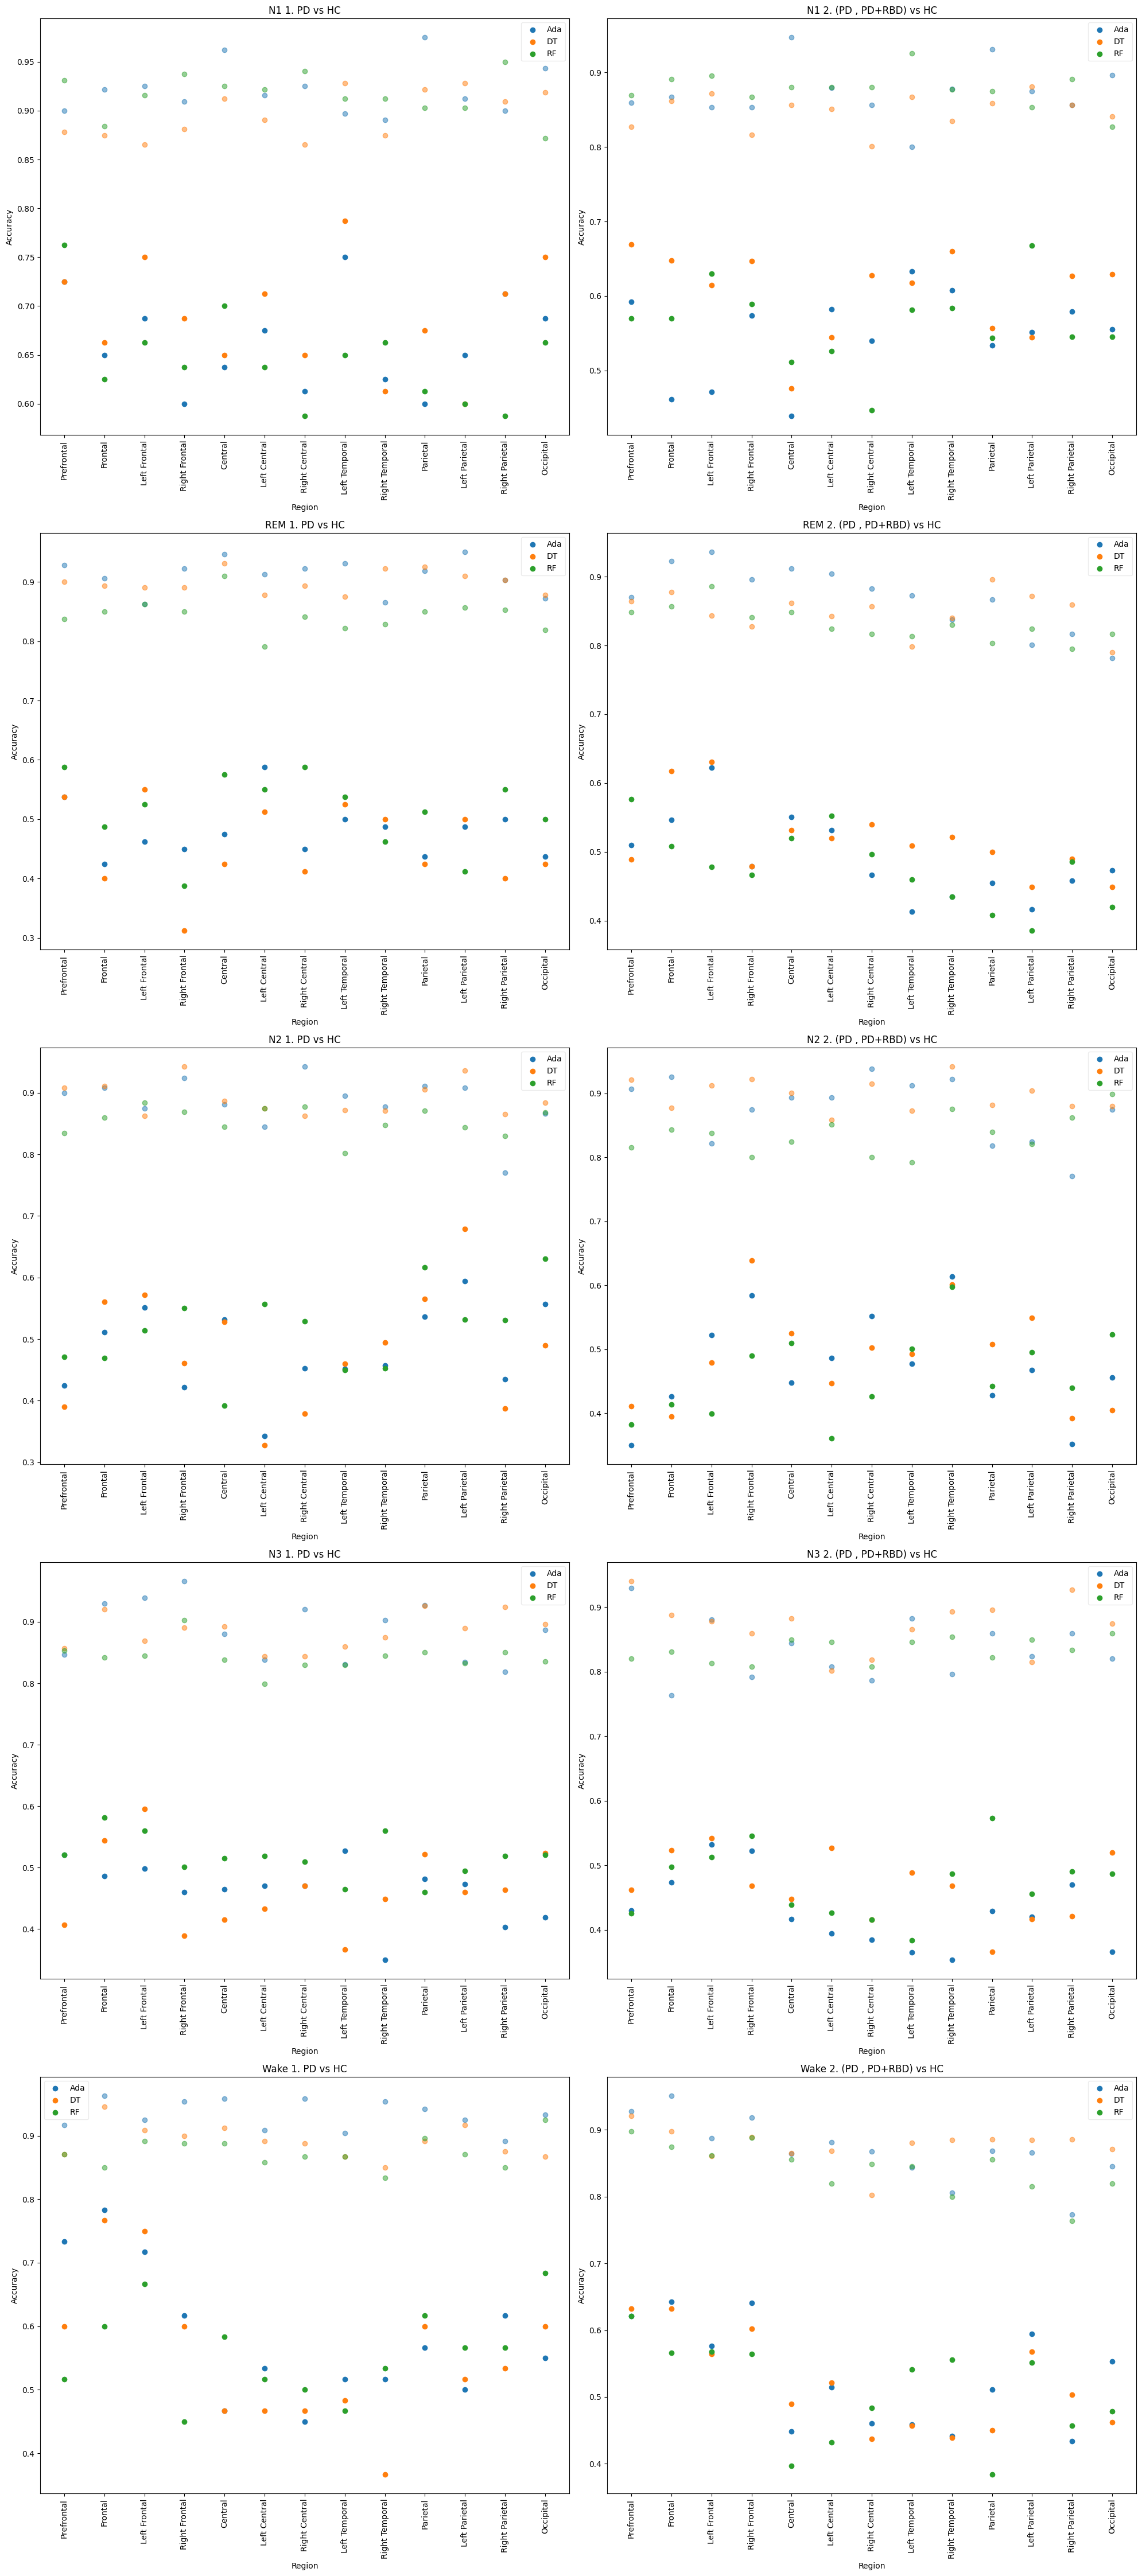

In [14]:
fig = plt.figure()
fig = plt.figure(figsize=(20,45),dpi=100)
i = 0 

for data_type in ['N1','REM', 'N2', 'N3', 'Wake']:
    for expt_num in ['1', '2']:
        i+= 1
        ax = fig.add_subplot(5,2,i)
        
        
        expt_info = [ '1. PD vs HC', '2. (PD , PD+RBD) vs HC', '3. (PD + PD&RBD) vs HC vs RBD', 
                     '4. PD vs PD+RBD vs RBD vs HC' ]
        plt.title( data_type + ' ' + expt_info[int(expt_num)-1])
        
        colors = {'Ada':'tab:blue', 'DT':'tab:orange', 'RF':'tab:green', 'SVC':'tab:red'}
        
        # for label , model in zip(['_Ada_acc', '_DT_acc' , '_RF_acc' , '_SVC_acc'], ['Ada' , 'DT' , 'RF', 'SVC']):
        for label , model in zip(['_Ada_acc', '_DT_acc' , '_RF_acc'], ['Ada' , 'DT' , 'RF']):
            file_name = model + '_' + data_type + '_' + 'bpw_only_' + TS_Fresh_setting + '_' + 'expt' + str(expt_num) + '_' +  str(4) + '_fold_results_df.pkl'
        
            all_results_df = joblib.load(folder+file_name)
            test_results_raw_df = all_results_df[['random_state' , 'y_true'] + [ col for col in all_results_df.columns if 'y_preds' in col]].copy()
            acc_df = return_acc_df(test_results_raw_df)
        
            train_results_raw_df = all_results_df[['random_state'] + [ col for col in all_results_df.columns if 'train' in col]].copy()
            train_results_raw_df.rename(columns={'y_train': 'y_true'}, inplace=True)
            train_results_raw_df.columns = train_results_raw_df.columns.str.replace('y_train_preds', 'y_preds')
            acc_train_df = return_acc_df(train_results_raw_df)
        
            plt.scatter([ val[:-len(label)] for val in acc_df.columns.values] , acc_df.values.ravel() , c = colors[model], label = model)
            plt.scatter([ val[:-len(label)] for val in acc_train_df.columns.values] , acc_train_df.values.ravel() , c = colors[model], alpha = 0.5)
            
            plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
            plt.xlabel('Region')
            plt.ylabel('Accuracy')
            
        #Only plot the legend for experiment 1
        plt.legend(framealpha = 0.4)
        plt.tight_layout()
        
plt.tight_layout()